<a href="https://www.kaggle.com/code/yunsuxiaozi/mnist-dataset-starter-notebook?scriptVersionId=168060755" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Created by yunsuxiaozi 2024/3/19

### MNIST数据集可以说是计算机视觉领域的"hello world",在本文当中,我将带大家搭建一个简单的CNN模型,来对这个数据集进行分类.(这里只是实现代码逻辑,如果想达到更好的效果可以尝试网络模型的加深和迭代次数的增加)

#### 首先是导入一些基础的库,这些库有的是读取csv文件的,有的是处理numpy或者torch.tensor数据的.

In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#一个强大的绘图库

import torch #一个深度学习的库Pytorch
import torch.nn as nn#neural network,神经网络
import torch.nn.functional as F#神经网络函数库
import torch.optim as optim#一个实现了各种优化算法的库
import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别。

#### 这里来设置一些参数

- seed:随机种子是为了保证每次程序运行的结果一致

- batch_size:batch_size是我们需要将所有的数据分批次进行训练.图像数据大小是(28,28)的矩阵,数据量为42000,就是(42000,28,28)的矩阵,如果遇到更大型的图像分类任务,将数据一次性传入模型,可能会出现内存不足的问题.

- num_epochs:模型的训练次数.

- num_classes:图像分类任务的类别数量.

- num_folds:这是K折交叉验证.交叉验证一般是在表格数据中使用,但是在这种小型图像数据同时计算资源足够的前提下,可以通过K折交叉验证达到更好的效果.

- train_path:训练数据的文件路径.

- test_path:测试数据的文件路径.

In [2]:
class Config:
    seed=2024#随机种子
    batch_size=128#每次传入的图像数据
    num_epochs=10#模型训练10个epoch即可.
    num_classes=10#图像的类别数.
    num_folds=5#5折交叉验证
    train_path="/kaggle/input/digit-recognizer/train.csv"
    test_path="/kaggle/input/digit-recognizer/test.csv"

#### 随机种子固定,保证程序可以复现.

In [3]:
#设置随机种子
import random
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True#将cuda加速的随机数生成器设为确定性模式
    torch.backends.cudnn.benchmark = False#关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
    torch.manual_seed(seed)#pytorch的随机种子
    np.random.seed(seed)#numpy的随机种子
    random.seed(seed)#python内置的随机种子
seed_everything(Config.seed)

我们这里先准备好训练数据和测试数据

In [4]:
train_df=pd.read_csv(Config.train_path)
X=train_df.drop(['label'],axis=1).values.reshape(-1,1,28,28)
y=train_df['label'].values
print(f"X.shape:{X.shape},y.shape:{y.shape}")
test_df=pd.read_csv(Config.test_path)
test_X=test_df.values.reshape(-1,1,28,28)
print(f"test_X.shape:{test_X.shape}")

X.shape:(42000, 1, 28, 28),y.shape:(42000,)
test_X.shape:(28000, 1, 28, 28)


#### 我们接下来搭建模型,这里是两层卷积层,一个全连接层和一个输出层.

- init:初始化函数,一般用来写神经网络的各种模块.

- forward:前向传播函数.图像数据在神经网络中做了什么都在这个函数实现.

In [5]:
class MNISTCNN(nn.Module):
    def __init__(self,num_classes=Config.num_classes):
        super(MNISTCNN,self).__init__()
        self.num_classes=num_classes
        self.conv=nn.Sequential(
                  #1*28*28->6*28*28
                  nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1,padding=1),
                  nn.BatchNorm2d(6),
                  #6*28*28->6*14*14
                  nn.MaxPool2d(kernel_size=2,stride=2),
                  nn.GELU(),
                  #6*14*14->64*14*14
                  nn.Conv2d(in_channels=6,out_channels=64,kernel_size=3,stride=1,padding=1),
                  nn.BatchNorm2d(64),
                  #64*14*14->64*7*7
                  nn.MaxPool2d(kernel_size=2,stride=2),
                  nn.GELU(),
        )
        self.head=nn.Sequential(
                nn.Linear(64*7*7,128),
                nn.BatchNorm1d(128),
                nn.GELU(),
                nn.Linear(128,self.num_classes),
        )
        
    def forward(self,x):
        x=self.conv(x).reshape(x.shape[0],-1)
        x=self.head(x)
        return F.softmax(x,dim=-1)

#### 接下来就是模型的训练了,这里用5折交叉验证训练5个神经网络.损失函数是交叉熵损失函数,评估指标是准确率.训练好一个模型可以作图看看训练数据和测试数据的损失和准确率情况,并作图.保存好训练好的模型.

device:cpu
fold:0------------------------
epoch:0
train_loss:0.6491035223007202,train_accuracy:0.8716619318181819
valid_loss:0.2675667405128479,valid_accuracy:0.9450451520912547
epoch:1
train_loss:0.264261931180954,train_accuracy:0.9505208333333334
valid_loss:0.22354325652122498,valid_accuracy:0.960224572243346
epoch:2
train_loss:0.16056901216506958,train_accuracy:0.9705255681818182
valid_loss:0.15556037425994873,valid_accuracy:0.9693738117870723
epoch:3
train_loss:0.11039015650749207,train_accuracy:0.9791666666666666
valid_loss:0.12140124291181564,valid_accuracy:0.9718096482889734
epoch:4
train_loss:0.0817752480506897,train_accuracy:0.9853219696969697
valid_loss:0.12115153670310974,valid_accuracy:0.9686608840304183
epoch:5
train_loss:0.06622640788555145,train_accuracy:0.9879971590909091
valid_loss:0.146293506026268,valid_accuracy:0.9584125475285171
epoch:6
train_loss:0.052530378103256226,train_accuracy:0.991311553030303
valid_loss:0.09032983332872391,valid_accuracy:0.9761169201520913


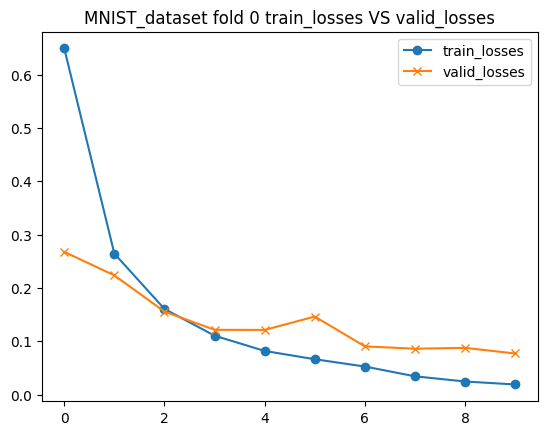

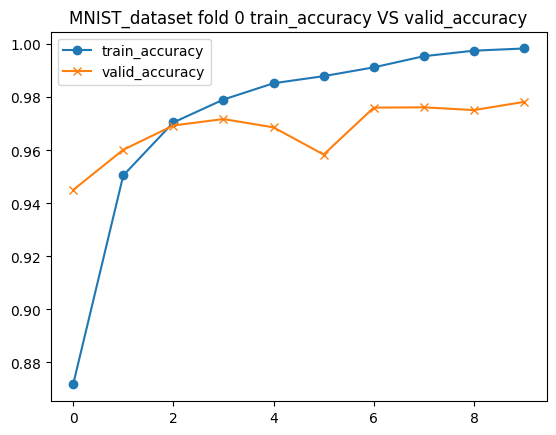

fold:1------------------------
epoch:0
train_loss:0.6833807229995728,train_accuracy:0.8557291666666667
valid_loss:0.30371779203414917,valid_accuracy:0.9349750475285171
epoch:1
train_loss:0.273689866065979,train_accuracy:0.9464015151515152
valid_loss:0.2557643949985504,valid_accuracy:0.9561549429657795
epoch:2
train_loss:0.15997765958309174,train_accuracy:0.9708333333333333
valid_loss:0.1762019246816635,valid_accuracy:0.962719819391635
epoch:3
train_loss:0.11078827828168869,train_accuracy:0.9812026515151516
valid_loss:0.14533570408821106,valid_accuracy:0.9644130228136882
epoch:4
train_loss:0.08222253620624542,train_accuracy:0.9864109848484849
valid_loss:0.14539670944213867,valid_accuracy:0.9598384030418251
epoch:5
train_loss:0.06357753276824951,train_accuracy:0.9910274621212122
valid_loss:0.10959207266569138,valid_accuracy:0.9706808460076045
epoch:6
train_loss:0.04461906850337982,train_accuracy:0.9933948863636365
valid_loss:0.08981649577617645,valid_accuracy:0.9770080798479087
epoch:7
t

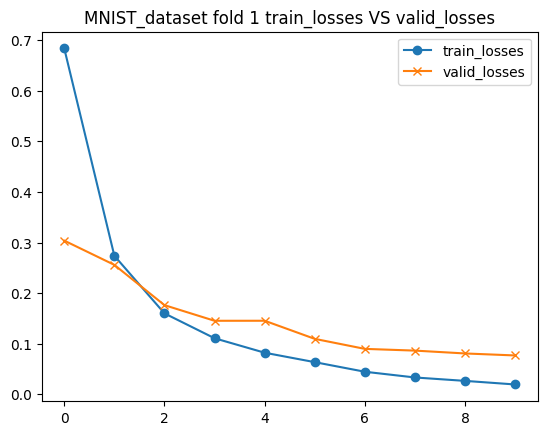

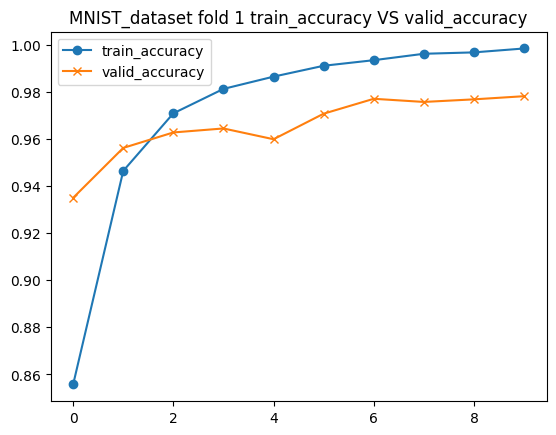

fold:2------------------------
epoch:0
train_loss:0.6941140294075012,train_accuracy:0.8642045454545455
valid_loss:0.306826114654541,valid_accuracy:0.936430608365019
epoch:1
train_loss:0.2759031653404236,train_accuracy:0.9494791666666667
valid_loss:0.23269356787204742,valid_accuracy:0.9629574619771863
epoch:2
train_loss:0.15877127647399902,train_accuracy:0.9724905303030303
valid_loss:0.16110330820083618,valid_accuracy:0.9708590779467681
epoch:3
train_loss:0.10635805130004883,train_accuracy:0.9837594696969696
valid_loss:0.12324424088001251,valid_accuracy:0.9728196292775665
epoch:4
train_loss:0.07384613901376724,train_accuracy:0.9905539772727273
valid_loss:0.1124272570014,valid_accuracy:0.9734434410646388
epoch:5
train_loss:0.05586079880595207,train_accuracy:0.9932765151515153
valid_loss:0.10352547466754913,valid_accuracy:0.9742454847908745
epoch:6
train_loss:0.04211843013763428,train_accuracy:0.9939630681818182
valid_loss:0.09366043657064438,valid_accuracy:0.9755822243346007
epoch:7
trai

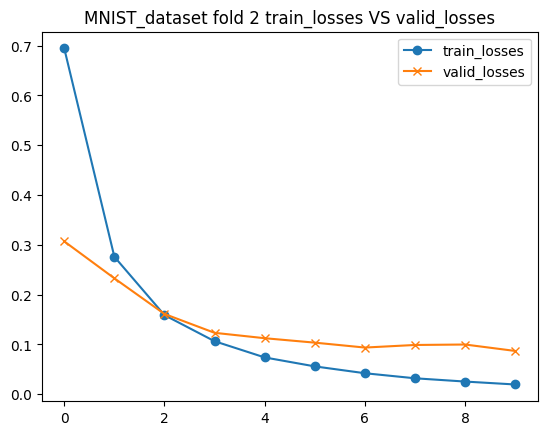

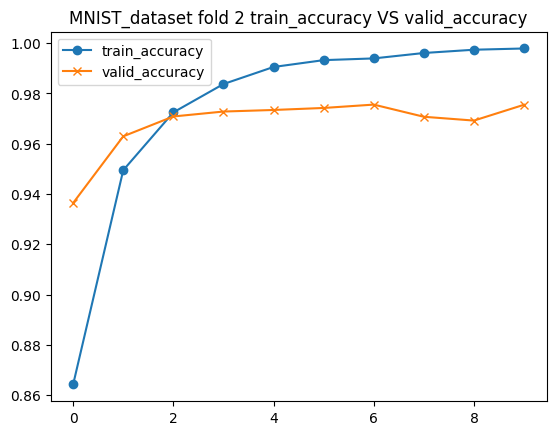

fold:3------------------------
epoch:0
train_loss:0.6855730414390564,train_accuracy:0.8642282196969697
valid_loss:0.29650551080703735,valid_accuracy:0.939282319391635
epoch:1
train_loss:0.2760518789291382,train_accuracy:0.9488873106060606
valid_loss:0.22886383533477783,valid_accuracy:0.9598384030418251
epoch:2
train_loss:0.16584224998950958,train_accuracy:0.9715672348484847
valid_loss:0.16366766393184662,valid_accuracy:0.968037072243346
epoch:3
train_loss:0.11586946994066238,train_accuracy:0.9794981060606059
valid_loss:0.13552755117416382,valid_accuracy:0.9690767585551331
epoch:4
train_loss:0.09068579226732254,train_accuracy:0.9841145833333332
valid_loss:0.13105890154838562,valid_accuracy:0.9675320817490495
epoch:5
train_loss:0.06163586303591728,train_accuracy:0.9906249999999999
valid_loss:0.10431882739067078,valid_accuracy:0.9729087452471483
epoch:6
train_loss:0.042196907103061676,train_accuracy:0.9951467803030303
valid_loss:0.09273890405893326,valid_accuracy:0.976206036121673
epoch:7

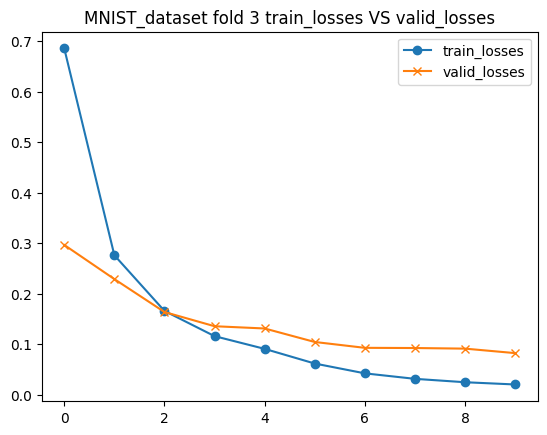

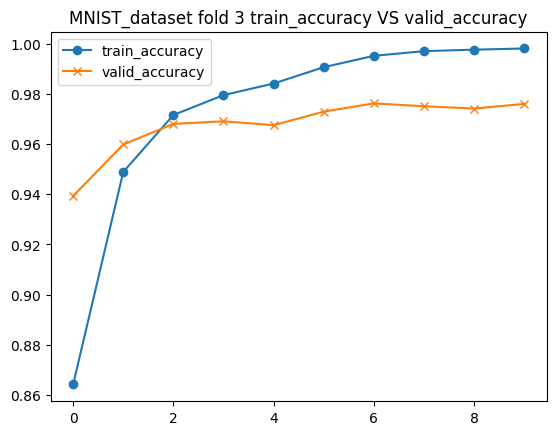

fold:4------------------------
epoch:0
train_loss:0.6897361874580383,train_accuracy:0.8620501893939394
valid_loss:0.3034139573574066,valid_accuracy:0.9383614543726235
epoch:1
train_loss:0.27307116985321045,train_accuracy:0.9508996212121212
valid_loss:0.24587911367416382,valid_accuracy:0.9589769486692015
epoch:2
train_loss:0.1599038988351822,train_accuracy:0.9729403409090909
valid_loss:0.16236010193824768,valid_accuracy:0.965215066539924
epoch:3
train_loss:0.10807850956916809,train_accuracy:0.9822206439393939
valid_loss:0.14615631103515625,valid_accuracy:0.9613830798479087
epoch:4
train_loss:0.08191993832588196,train_accuracy:0.9879261363636364
valid_loss:0.11487767100334167,valid_accuracy:0.9686905893536122
epoch:5
train_loss:0.05559983104467392,train_accuracy:0.9923058712121212
valid_loss:0.09943076968193054,valid_accuracy:0.9746613593155894
epoch:6
train_loss:0.040575966238975525,train_accuracy:0.9952651515151515
valid_loss:0.09103532880544662,valid_accuracy:0.9761763307984791
epoch:

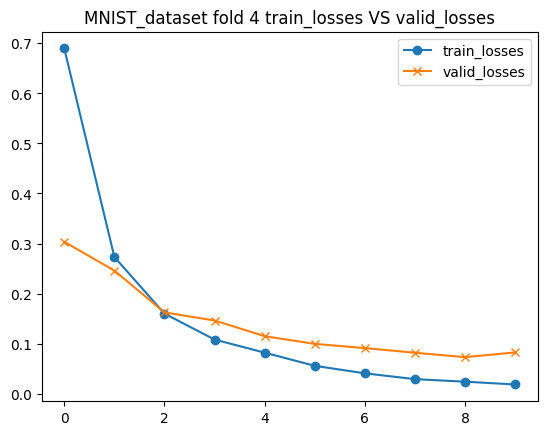

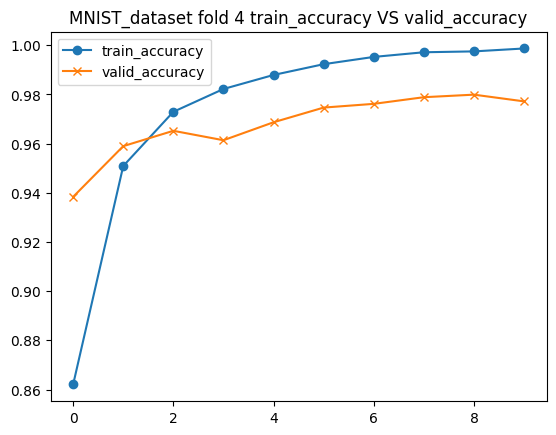

In [6]:
def cross_entropy_loss(y_pro,y_target,eps=1e-15):
    y_target=torch.eye(int(y_pro.shape[-1]))[y_target]
    y_pro=torch.clip(y_pro,eps,1-eps)
    y_target=torch.clip(y_target,eps,1-eps)
    return -torch.mean(torch.sum(y_target*torch.log(y_pro),dim=1),dim=0)
def accuracy(y_true,y_pred):
    return np.mean(y_true==y_pred)

device='cuda' if torch.cuda.is_available() else"cpu"
print(f"device:{device}")

total_idx=np.arange(len(X))
np.random.shuffle(total_idx)
for fold in range(Config.num_folds):
    print(f"fold:{fold}------------------------")
    #交叉验证每次训练数据和验证数据的划分
    train_idx=total_idx[fold*len(X)//Config.num_folds:(fold+1)*len(X)//Config.num_folds]
    valid_idx=[idx for idx in total_idx if idx not in train_idx]
    train_X,train_y=X[train_idx],y[train_idx]
    valid_X,valid_y=X[valid_idx],y[valid_idx]
    #模型设置
    model=MNISTCNN().to(device)
    #优化器设置
    optimizer=optim.Adam(model.parameters(),lr=0.00025,betas=(0.5,0.999))
    train_losses=[]
    valid_losses=[]
    train_accuracys=[]
    valid_accuracys=[]
    for epoch in range(Config.num_epochs):
        print(f"epoch:{epoch}")
        #模型设置为训练状态
        model.train()
        #将梯度清空
        optimizer.zero_grad()
        train_loss=[]
        train_accuracy=[]
        for idx in range(0,len(train_X),Config.batch_size):
            train_X1=torch.Tensor(train_X[idx:idx+Config.batch_size])
            train_y1=torch.Tensor(train_y[idx:idx+Config.batch_size]).long()
            train_pro=model(train_X1)
            loss=cross_entropy_loss(train_pro,train_y1)
            train_pred=torch.argmax(train_pro,axis=1).detach().numpy()
            train_y1=train_y1.detach().numpy()
            #反向传播
            loss.backward()
            #优化器进行优化(梯度下降,降低误差)
            optimizer.step()
            train_loss.append(loss.detach().numpy())
            train_accuracy.append(accuracy(train_y1,train_pred))
        train_loss=np.mean(np.array(train_loss))
        train_accuracy=np.mean(np.array(train_accuracy))
        print(f"train_loss:{train_loss},train_accuracy:{train_accuracy}")
        #模型设置为评估模式
        model.eval()
        with torch.no_grad():
            valid_loss=[]
            valid_accuracy=[]
            for idx in range(0,len(valid_X),Config.batch_size):
                valid_X1=torch.Tensor(valid_X[idx:idx+Config.batch_size])
                valid_y1=torch.Tensor(valid_y[idx:idx+Config.batch_size]).long()
                valid_pro=model(valid_X1)
                loss=cross_entropy_loss(valid_pro,valid_y1)
                valid_pred=torch.argmax(valid_pro,axis=1).detach().numpy()
                valid_y1=valid_y1.detach().numpy()
                valid_loss.append(loss.detach().numpy())
                valid_accuracy.append(accuracy(valid_y1,valid_pred))
        valid_loss=np.mean(np.array(valid_loss))
        valid_accuracy=np.mean(np.array(valid_accuracy))
        print(f"valid_loss:{valid_loss},valid_accuracy:{valid_accuracy}")
        train_losses.append(train_loss)
        train_accuracys.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracys.append(valid_accuracy)
    torch.save(model,f"fold{fold}.pth")
    epochs=np.arange(Config.num_epochs)
    plt.title(f"MNIST_dataset fold {fold} train_losses VS valid_losses")
    plt.plot(epochs,train_losses,marker="o",label="train_losses")
    plt.plot(epochs,valid_losses,marker="x",label="valid_losses")
    plt.legend()
    plt.show()
    plt.title(f"MNIST_dataset fold {fold} train_accuracy VS valid_accuracy")
    plt.plot(epochs,train_accuracys,marker="o",label="train_accuracy")
    plt.plot(epochs,valid_accuracys,marker="x",label="valid_accuracy")
    plt.legend()
    plt.show()

#### 这里使用训练好的模型对测试数据进行预测.

In [7]:
print("eval")
test_pros=np.zeros((Config.num_folds,len(test_X),Config.num_classes))
for fold in range(Config.num_folds):
    print(f"fold:{fold}")
    model=torch.load(f"fold{fold}.pth")
    model.eval()
    with torch.no_grad():
        for idx in range(0,len(test_X),Config.batch_size):
            test_X1=torch.Tensor(test_X[idx:idx+Config.batch_size])
            test_pro=model(test_X1).detach().numpy()
            test_pros[fold,idx:idx+len(test_X1)]=test_pro
test_pros=test_pros.mean(axis=0)
test_preds=np.argmax(test_pros,axis=1)
test_preds

eval
fold:0
fold:1
fold:2
fold:3
fold:4


array([2, 0, 9, ..., 3, 9, 2])

#### 最后,可以将预测结果赋值给submission,然后进行提交.

In [8]:
submission=pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission['Label']=test_preds
submission.to_csv("submission.csv",index=None)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
